# Detecció d'opinions

In [2]:
# NLTK
import nltk
from nltk.corpus import movie_reviews as mr
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('movie_reviews')
nltk.download('stopwords')

# Plots:
import matplotlib.pyplot as plt
import numpy as np

# Pickle:
import pickle

# Sklearn
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Typing
from typing import Any, Dict, List, Tuple, Type

# Requisitos para el typing
SklearnEstimator = Type[BaseEstimator]


[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/barre/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package stopwords to /home/barre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
corpus = mr.fileids()[0]
".".isalpha()


False

In [3]:
def preprocess(review: str)-> str:
    """
    Función que preprocesa una review del corpus.

    Parámetros:
    - review: String de una review.

    Retorna:
    - review: Una string con review preprocesada:
                - sin mayúsculas.
                - sin dígitos.
                - sin saltos de línea (\n).
                - lematizada cada palabra.
                - separadas por un espacio (" ").
    """
    review = review.lower()
    # eliminate any character that is not a letter or a space
    review = ''.join(c for c in review if c.isalpha() or c == ' ')
    review = review.replace('\n', ' ')
    # convert all the words to its lemma
    lemmatizer = nltk.WordNetLemmatizer()
    
    review = ' '.join(lemmatizer.lemmatize(word) for word in review.split())
    # remove stopwords
    stopwords = set(nltk.corpus.stopwords.words('english'))
    review = [w for w in review if w not in stopwords]
    review = ' '.join(review)
    return review

def split_corpus(X: List[str], y: list, test_size = 0.2, random_state = 42) -> Tuple[List, List, List, List]:
    """
    Función que divide el corpus y el vector y en X_train, X_test, y_train y y_test.

    Parámetros:
    - x: Lista de string siendo dicha string una review preprocesada y la lista conteniendo todas ellas.
    - y: Lista compuesta de "pos" o "neg", según si la review del corpus con el mismo índice es positiva o negativa.
    - test_size: Float indicando proporción de test del corpus.
    - random_state: Número entero indicando la semilla para separar el corpus.

    Retorna: 
    - X_train
    - X_test
    - y_train
    - y_test
        -> Conjunto de X e y separadas según train y test, siendo las X (train y test) vectorizadas.
    """
    vectorizer = CountVectorizer()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    return X_train, X_test, y_train, y_test

corpus = [preprocess(mr.raw(review)) for review in mr.fileids()]
y = ["pos"]*1000 + ["neg"]*1000 

X_train, X_test, y_train, y_test = split_corpus(corpus, y)


In [5]:
print(X_test)

  (0, 76)	1
  (0, 80)	1
  (0, 105)	1
  (0, 165)	1
  (0, 223)	1
  (0, 270)	1
  (0, 333)	1
  (0, 534)	1
  (0, 559)	1
  (0, 561)	1
  (0, 760)	1
  (0, 778)	3
  (0, 863)	2
  (0, 875)	1
  (0, 912)	1
  (0, 1015)	1
  (0, 1070)	4
  (0, 1113)	29
  (0, 1217)	5
  (0, 1364)	1
  (0, 1386)	1
  (0, 1395)	1
  (0, 1547)	3
  (0, 1552)	1
  (0, 1615)	1
  :	:
  (399, 34876)	1
  (399, 34893)	1
  (399, 35244)	1
  (399, 35334)	1
  (399, 35380)	1
  (399, 35413)	1
  (399, 35467)	1
  (399, 35472)	1
  (399, 35501)	1
  (399, 35581)	1
  (399, 36100)	2
  (399, 36220)	2
  (399, 36221)	1
  (399, 36338)	2
  (399, 36439)	1
  (399, 36598)	1
  (399, 36602)	1
  (399, 36619)	2
  (399, 36699)	2
  (399, 36931)	1
  (399, 36937)	4
  (399, 36989)	1
  (399, 37115)	1
  (399, 37124)	1
  (399, 37387)	1


## MODELOS SUPERVISADOS

### Funciones para realizar búsquedas "greedy" y visualizar los resultados

In [29]:


def grid_search(classifier: BaseEstimator, classifier_str: str, params: Dict[str, List], hacer_grid_search = True, kfolds = 5) -> GridSearchCV:
    """
    Esta función realiza una búsqueda de hiperparámetros utilizando GridSearchCV y
    guarda los resultados en un archivo binario si se especifica "hacer_grid_search" como True.
    Si "hacer_grid_search" es False, carga los resultados previamente guardados del archivo binario.

    Parámetros:
    - classifier: Instancia de BaseEstimador de Sklearn.
    - classifier_str: Una cadena que representa el nombre del modelo para guardar o abrir el archivo binario, debería ser diferente para cada modelo.
    - params: Un diccionario que contiene los hiperparámetros a ajustar en el GridSearchCV.
    - hacer_grid_search: Un booleano que indica si se debe realizar una nueva búsqueda GridSearchCV
                         (predeterminado es True).
    - kfolds: Número entero (int) de subsets de validación que se utilizarán para evitar overfitting.
              Sólo se utilizará en caso de realizar la "grid_search", es decir, en caso de que "hacer_grid_search" sea True.

    Retorna:
    - grid_search_result: Una instancia de GridSearchCV que contiene los resultados de la búsqueda de hiperparámetros.
    """

    # Realizar la búsqueda en caso de que se quiera buscar con parámetros nuevos
    if hacer_grid_search:
        grid_search_result = GridSearchCV(classifier, params, cv=kfolds)
        grid_search_result.fit(X_train, y_train)

        # Guardar en un archivo binario la instancia de GridSearchCV ejecutada con el modelo escogido
        with open(f'./bin/{classifier_str}_grid_search.bin', "wb+") as file:
            pickle.dump(grid_search_result, file)

    # En caso de no querer realizar otra vez la búsqueda, se carga del binario
    else:
        with open(f'./bin/{classifier_str}_grid_search.bin', "rb") as file:
            grid_search_result = pickle.load(file)
    print(grid_search_result.best_params_)
    print(grid_search_result.best_score_)
    return grid_search_result



def plot_gridsearch(grid: GridSearchCV, param_grid: Dict[str, list], x, y, xlab, ylab, z=None):
    """
    Función que crea una gráfica con los resultados de la búsqueda ambiciosa.

    Parámetros:
    - grid: Instancia de GridSearchCV con la búsqueda "greedy" con distintos alpha-s.
    - param_grid: dict conteniendo las alpha-s con las que se ha realizado la búsqueda.
    - x: String con la variable de param_grid que pertenecerá al eje x.
    - y: String con la variable de param_grid que pertenecerá al eje y, normalmente la métrica de performance.
    - xlab: Label del eje x.
    - ylab: Label del eje y.
    - z: En caso de querer ver algún otro parámetro, string con el parámetro que creará líneas de distintos 
         colores para cada valor de dicho parámetro, en función de la x y la y es None por defecto. 
    
    """

    scores = grid.cv_results_[y]

    length_x = len(param_grid[x])
    if z != None:
        length_z = len(param_grid[z])
    else:
        length_z = 1

    for i in range(length_z):
        plt.plot(param_grid[x], scores[i*length_x:(i+1)*length_x])
    
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.axvline(grid.best_params_[x], color='r',alpha = 0.3)
    if z!= None:
        plt.legend(param_grid[z])
    plt.show()

***
### **Modelo Multinomial**
***

{'alpha': 3.0}
MultinomialNB(alpha=3.0)


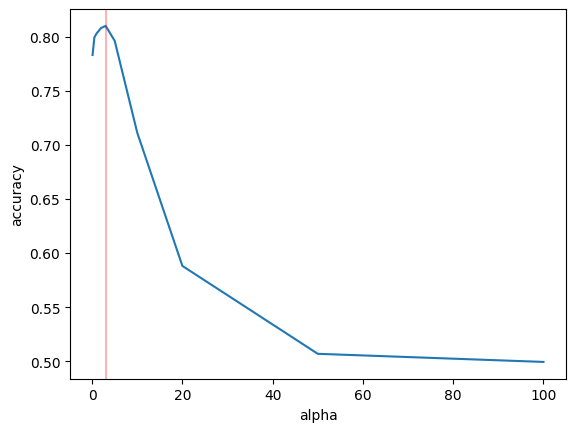

In [23]:
# Búsqueda greedy para escoger el mejor parámetro
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0,3.0,5.0,10.0,20.0,50.0,100.0]}
grid_multinomial = grid_search(MultinomialNB(), "multinomial", param_grid, True)

# Plot del accuracy en función de alpha
plot_gridsearch(grid_multinomial, param_grid, "alpha", "mean_test_score", "alpha", "accuracy")

In [9]:
multinomial = MultinomialNB(alpha=grid_multinomial.best_params_["alpha"])
multinomial.fit(X_train, y_train)

MultinomialNB(alpha=3.0)

***
### **Support Vector Machine**
***

In [33]:
svc_parameters = {'kernel':('linear', 'rbf'), 'C':[0.1,1,5,10,20]}

grid_svc = grid_search(SVC(), "SVC", svc_parameters, False)

{'C': 10, 'kernel': 'rbf'}
0.826875


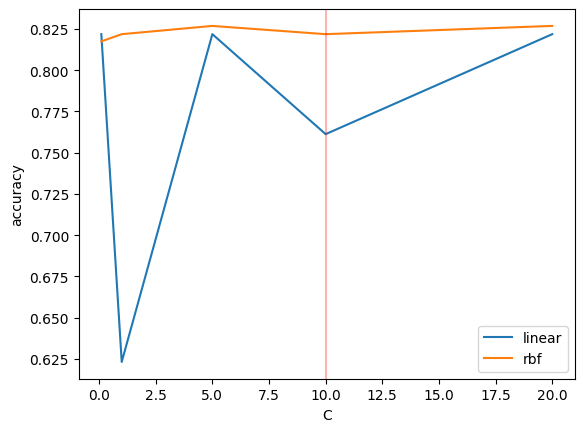

"scores = grid_svc.cv_results_['mean_test_score']\nC = [0.1,1,5,10,20]\nplt.plot(C, scores[:5])\nplt.xlabel('C')\nplt.ylabel('accuracy')\nplt.plot(C, scores[5:])\nplt.axvline(grid_svc.best_params_['C'], color='r', alpha = 0.3)\n# legend\nplt.legend(['linear', 'rbf'])\nplt.show()"

In [32]:
# plot only the linear kernel and its score depending on the C parameter
plot_gridsearch(grid_svc, svc_parameters, "C", "mean_test_score", "C", "accuracy", "kernel")

"""scores = grid_svc.cv_results_['mean_test_score']
C = [0.1,1,5,10,20]
plt.plot(C, scores[:5])
plt.xlabel('C')
plt.ylabel('accuracy')
plt.plot(C, scores[5:])
plt.axvline(grid_svc.best_params_['C'], color='r', alpha = 0.3)
# legend
plt.legend(['linear', 'rbf'])
plt.show()"""

In [34]:
svc = SVC(kernel=grid_svc.best_params_["kernel"], C=grid_svc.best_params_["C"])
svc.fit(X_train, y_train)

SVC(C=10)

***
### **Regresión Logística**
***

In [35]:
from sklearn.linear_model import LogisticRegression
parameters_logreg = {'C':[0.1,1,5,10,20,30,50,75,100]}
logreg = LogisticRegression(max_iter=1000)

grid_logreg = grid_search(logreg, "log_reg", parameters_logreg, False)


{'C': 10}
0.838125


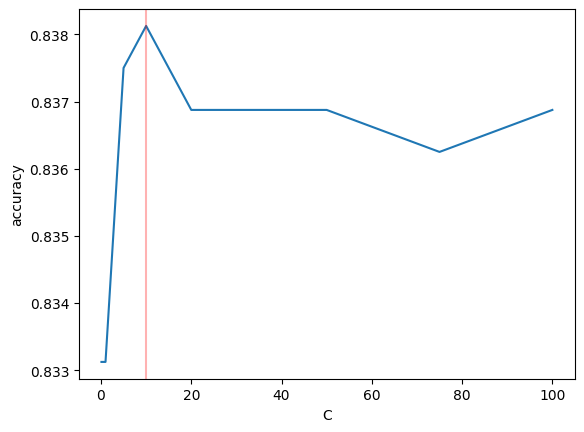

"\nscores = grid_logreg.cv_results_['mean_test_score']\nC = [0.1,1,5,10,20,30,50,75,100]\nplt.plot(C, scores)\nplt.xlabel('C')\nplt.ylabel('accuracy')\nplt.axvline(grid_logreg.best_params_['C'], color='r', alpha = 0.3)\nplt.show()"

In [38]:
# plot the results of the gridsearch
plot_gridsearch(grid_logreg, parameters_logreg, "C", "mean_test_score", "C", "accuracy")
"""
scores = grid_logreg.cv_results_['mean_test_score']
C = [0.1,1,5,10,20,30,50,75,100]
plt.plot(C, scores)
plt.xlabel('C')
plt.ylabel('accuracy')
plt.axvline(grid_logreg.best_params_['C'], color='r', alpha = 0.3)
plt.show()"""

In [40]:
log_reg = LogisticRegression(C = grid_logreg.best_params_["C"], max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000)

***
### **Random Forest**
***

### Gridsearch - Trobem els millors hiperparàmetres

In [36]:
from sklearn.ensemble import RandomForestClassifier
params_rndm_forest = {'n_estimators': [10, 25, 50, 100], 'max_depth': [None, 10, 20, 30, 40, 50]}
grid_rndm_forest = grid_search(RandomForestClassifier(), "rndm_forest", params_rndm_forest, False)

{'max_depth': 30, 'n_estimators': 100}
0.8006249999999999


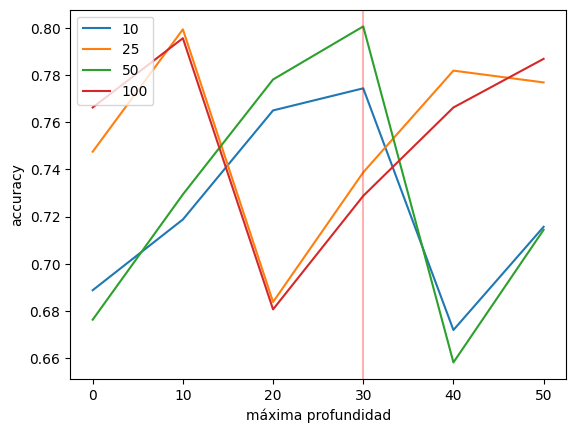

"scores = grid_rndm_forest.cv_results_['mean_test_score']\nmax_depth = [0, 10, 20, 30, 40, 50]\n\n# fem un plot de cada n_estimators amb el seu color\nfor i in range(4):\n    plt.plot(max_depth, scores[i*6:(i+1)*6])\n\nplt.legend(['10', '25', '50', '100'], title = 'n_estimators')\nplt.xlabel('max_depth')\nplt.ylabel('accuracy')\nplt.axvline(grid_rndm_forest.best_params_['max_depth'], color='r', alpha = 0.3)\nplt.show()"

In [37]:

params_rndm_forest["max_depth"][0] = 0
plot_gridsearch(grid_rndm_forest, params_rndm_forest, "max_depth", "mean_test_score", "máxima profundidad", "accuracy", "n_estimators")


"""scores = grid_rndm_forest.cv_results_['mean_test_score']
max_depth = [0, 10, 20, 30, 40, 50]

# fem un plot de cada n_estimators amb el seu color
for i in range(4):
    plt.plot(max_depth, scores[i*6:(i+1)*6])

plt.legend(['10', '25', '50', '100'], title = 'n_estimators')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.axvline(grid_rndm_forest.best_params_['max_depth'], color='r', alpha = 0.3)
plt.show()"""



In [43]:
rndm_forest = RandomForestClassifier(n_estimators=100,max_depth=30, random_state=42)
rndm_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, random_state=42)

## Fem les proves amb Test

In [44]:
scores = {}

In [45]:
accuracy = classifier.score(X_test, y_test)
print("Accuracy:", accuracy)
name = str(classifier)
scores[str(name)] = accuracy

Accuracy: 0.79


In [46]:
# predict the category of a new review
new_review = "I love this movie, it is the best movie i have ever seen"
new_review = preprocess(new_review)
print(new_review)
new_review_vec = vectorizer.transform([new_review])
print(classifier.predict(new_review_vec))

i love this movie it is the best movie i have ever seen


NotFittedError: Vocabulary not fitted or provided

              precision    recall  f1-score   support

         neg       0.82      0.77      0.79       201
         pos       0.78      0.83      0.80       199

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



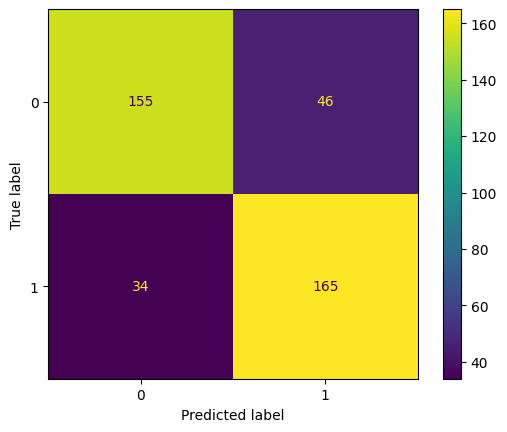

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
results = classifier.predict(X_test)
print(classification_report(y_test, results))
conf_matrix = confusion_matrix(y_test, results)
conf_matrix = ConfusionMatrixDisplay(conf_matrix)
conf_matrix.plot()
plt.show()


In [ ]:
import pandas as pd
df = pd.DataFrame(scores, index=[0])
# set the first row name as "accuracy"
df = df.rename(index={0: "Accuracy:"})
# change the fourth column name to Random forest
df = df.rename(columns={str(classifier): "RandomForest(n = 25)"})
df.head(1)


,SVC(C=5),"RandomForestClassifier(max_depth=30, random_state=42)","RandomForestClassifier(max_depth=30, n_estimators=50, random_state=42)","LogisticRegression(C=10, max_iter=1000)",SVC(C=10),RandomForest(n = 25)
Accuracy:,0.8,0.79,0.75,0.825,0.825,0.8125


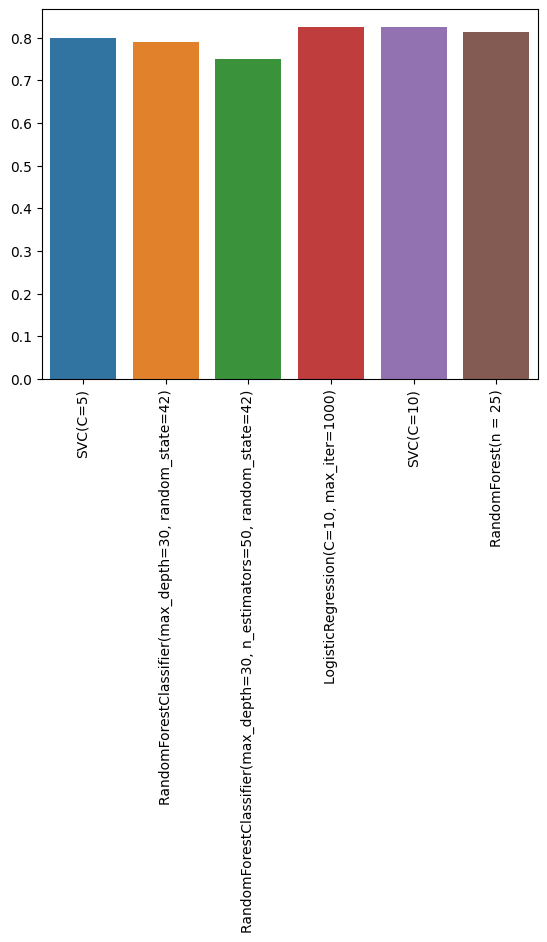

In [ ]:
# make a barplot to compare scores of df
sns.barplot(data=df)
# put the labels diagonally
plt.xticks(rotation=90)
plt.show()